Directory cleared. Current contents: ['.config', 'sample_data']


Saving utils.py to utils.py
Saving theft_protection.zip to theft_protection.zip
Contents of theft_protection.zip:
['single_thread/', 'single_thread/.DS_Store', 'single_thread/version description.rtf', 'single_thread/version_1/', 'single_thread/version_1/.DS_Store', 'single_thread/version_1/normal/', 'single_thread/version_1/normal/.DS_Store', 'single_thread/version_1/normal/arcive/', 'single_thread/version_1/normal/arcive/log0', 'single_thread/version_1/normal/arcive/log1', 'single_thread/version_1/normal/arcive/log2', 'single_thread/version_1/normal/arcive/log3', 'single_thread/version_1/normal/arcive/trace0', 'single_thread/version_1/normal/arcive/trace1', 'single_thread/version_1/normal/arcive/trace2', 'single_thread/version_1/normal/arcive/trace3', 'single_thread/version_1/normal/log00', 'single_thread/version_1/normal/log01', 'single_thread/version_1/normal/log02', 'single_thread/version_1/normal/log03', 'single_thread/version_1/normal/log10', 'single_thread/version_1/normal/log11

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                       │ (None, 30, 128)             │          67,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_47 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 116,610 (455.51 KB)

 Trainable params: 116,610 (455.51 KB)

 Non-trainable params: 0 (0.00 B)

Streaming output truncated to the last 5000 lines.
  - Detected in trace_trial1 at 780th event
  - Detected in trace_trial1 at 781th event
  - Detected in trace_trial1 at 782th event
  - Detected in trace_trial1 at 785th event
  - Detected in trace_trial1 at 786th event
  - Detected in trace_trial1 at 788th event
  - Detected in trace_trial1 at 789th event
  - Detected in trace_trial1 at 791th event
  - Detected in trace_trial1 at 792th event
  - Detected in trace_trial1 at 793th event
  - Detected in trace_trial1 at 798th event
  - Detected in trace_trial1 at 799th event
  - Detected in trace_trial1 at 800th event
  - Detected in trace_trial1 at 805th event
  - Detected in trace_trial1 at 806th event
  - Detected in trace_trial1 at 807th event
  - Detected in trace_trial1 at 808th event
  - Detected in trace_trial1 at 811th event
  - Detected in trace_trial1 at 812th event
  - Detected in trace_trial1 at 814th event
  - Detected in trace_trial1 at 815th event
  - Detected in trace_tri

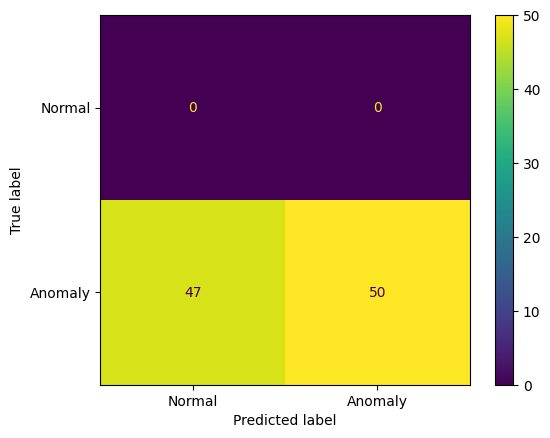

In [ ]:
import os
import numpy as np
import pandas as pd
import json
import shutil
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import zipfile
from google.colab import files
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


## Delete existing files from the directory before the code execution to ensure it is clean
current_dir = './'
for item in os.listdir(current_dir):
    # Skip system folders like '.config'
    if item not in ['.config', 'sample_data']:
        item_path = os.path.join(current_dir, item)
        # Delete files
        if os.path.isfile(item_path):
            os.remove(item_path)
        # Delete directories
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

print("Directory cleared. Current contents:", os.listdir(current_dir))


## Now upload files from the local directory
uploaded = files.upload()

## Here I am uploading the file as .zip so we need to extract them.
zip_file_path = './theft_protection.zip'
extraction_path = './theft_protection'
base_dir = './trace_data'

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print("Contents of theft_protection.zip:")
        print(zip_ref.namelist())
        zip_ref.extractall(extraction_path)
    print("Extraction complete. Contents have been extracted to: {extraction_folder}")

    ## Creating the trace_data directory to maintain the same folder structure like previous code.
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    ## Move the extracted files to this base directory.
    if os.path.exists('./theft_protection'):
        shutil.move('./theft_protection', f'{base_dir}/theft_protection')

else:
    print("Zip file not found.")


from utils import get_paths, read_traces, read_json, mapint2var, is_consistent



############ Configuration ################
CODE = 'theft_protection'           ## Code base name
BEHAVIOUR_FAULTY = 'faulty_data'    ## Normal or Faulty_data
BEHAVIOUR_NORMAL = 'normal'         ## Normal or Faulty_data
THREAD = 'single'                   ## Single or multi
VER = 3                             ## Version of data collection

## base_dir = '../trace_data'                      ##'../trace_data'
normalbase_path = f'{base_dir}/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_NORMAL}'    ## Data path for normal data set
faultybase_path = f'{base_dir}/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_FAULTY}'    ## Data path for faulty data set

## Printing the path for testing
print("Normal base path:", normalbase_path)
print("Faulty base path:", faultybase_path)





train_base_path = os.path.join(normalbase_path, 'train_data')                             ## Pointing to the path '/trace_data/theft_protection/single_thread/version_3/normal/train_data'
train_data_path = [os.path.join(train_base_path, x) for x in os.listdir(train_base_path)]
train_varlist_path = os.listdir(normalbase_path)
train_varlist_path = [os.path.join(normalbase_path, x) for x in train_varlist_path if 'varlist' in x]

print("train_data_path is : ",train_data_path)
print("train varlist path is :", train_varlist_path)

## Get paths
paths_log, paths_traces, varlist_path, paths_label = get_paths(faultybase_path)

## Remove .DS_Store from all the lists
train_data_path = [x for x in train_data_path if '.DS_Store' not in x]
train_varlist_path = [x for x in train_varlist_path if '.DS_Store' not in x]
paths_log = [x for x in paths_log if '.DS_Store' not in x]
paths_traces = [x for x in paths_traces if '.DS_Store' not in x]
varlist_path = [x for x in varlist_path if '.DS_Store' not in x]
paths_label = [x for x in paths_label if '.DS_Store' not in x]

paths_log.sort()
paths_traces.sort()
varlist_path.sort()
paths_label.sort()

## Print for test purpose
print("The paths log is :", paths_log)
print("The paths traces is :", paths_traces)
print("The varlist path is :", varlist_path)
print("The paths label is :", paths_label)

test_data_path = paths_traces
test_label_path = paths_label

print("The train data path is :", train_data_path)
print("The test data path is :", test_data_path)
print("The test label path is :", test_label_path)
print("The varlist path is :", varlist_path)



####### Check  varlist is consistent #####
####### Only for version 3 ###############
if VER == 3:
    check_con, _ = is_consistent([train_varlist_path[0]] + varlist_path)

    if check_con != False:
        to_number = read_json(varlist_path[0])
        from_number = mapint2var(to_number)
    else:
        print("Loading normal varlist")
        to_number = read_json(train_varlist_path[0])
        from_number = mapint2var(to_number)

## For testing purpose
print("The to_number is :", to_number)
print("The from_number is :", from_number)


## Get Variable List ##
sorted_keys = list(from_number.keys())
sorted_keys.sort()
var_list = [from_number[key] for key in sorted_keys]

print("The var_list is :", var_list)





# Step 1: Load and Preprocess Training Data
def load_data(file_paths):
    data = []
    for file in file_paths:
        traces = read_traces(file)  # Custom function to load traces
        if isinstance(traces, list):
            data.extend(traces)
        else:
            print(f"Unexpected data format in {file}")
    return np.array(data)


## Loading the training data
train_data = load_data(train_data_path)
print(f"Loaded train data shape: {train_data.shape}")

## Normalise the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
## Prepare data for LSTM
sequence_length = 30
X_train, y_train = [], []
for i in range(len(train_data_scaled) - sequence_length):
    X_train.append(train_data_scaled[i:i + sequence_length])
    y_train.append(train_data_scaled[i + sequence_length])

X_train = np.array(X_train)
y_train = np.array(y_train)

## print for testing purpose
print("The x_train is :", X_train)
print("The y train is :",y_train)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


## Define LSTM Model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(sequence_length, train_data_scaled.shape[1])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(X_train.shape[2], activation='linear')  # Output layer
])

model.compile(optimizer='adam', loss='mse')
model.summary()

## Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

## Test data preprocessing
test_data = load_data(test_data_path)
print(f"Loaded test data shape: {test_data.shape}")
test_data_scaled = scaler.transform(test_data)

## Prepare test data for LSTM
X_test, y_test = [], []
for i in range(len(test_data_scaled) - sequence_length):
    X_test.append(test_data_scaled[i:i + sequence_length])
    y_test.append(test_data_scaled[i + sequence_length])

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


## Make predictions on test data
predictions = model.predict(X_test)
errors = np.mean(np.abs(predictions - y_test), axis=1)
train_predictions = model.predict(X_train)
train_errors = np.mean(np.abs(train_predictions - y_train), axis=1)

threshold = np.percentile(train_errors,40)
anomalies = errors > threshold

## Anomaly detection
print("\nDetected anomalies:")
cumulative_lengths = [0]
for file in test_data_path:
    traces = read_traces(file)
    intervals = len(traces) - sequence_length
    cumulative_lengths.append(cumulative_lengths[-1] + max(intervals, 0))

anomaly_summary = {}
for i, is_anomaly in enumerate(anomalies):
    if is_anomaly:
        max_error_index = np.argmax(np.abs(predictions[i] - y_test[i]))
        file_index = next((idx for idx, val in enumerate(cumulative_lengths) if i < val), len(cumulative_lengths) - 1) - 1
        if 0 <= file_index < len(test_data_path):
            current_file_name = os.path.basename(test_data_path[file_index]).split('.')[0]
        else:
            current_file_name = "Unknown_File"

        event = i + sequence_length
        if max_error_index not in anomaly_summary:
            anomaly_summary[max_error_index] = []
        anomaly_summary[max_error_index].append((current_file_name, event))

for variable, events in anomaly_summary.items():
    print(f"\nVariable {variable}:")
    for file_name, event in events:
        print(f"  - Detected in {file_name} at {event}th event")


## Evaluation
ground_truth = []
for label_path in test_label_path:
    ground_truth_raw = read_traces(label_path)
    ground_truth.append(ground_truth_raw['labels'][list(ground_truth_raw['labels'].keys())[0]])
ground_truth = np.concatenate(ground_truth)

print("Raw ground_truth values:", ground_truth)
print(f"Original ground truth shape: {ground_truth.shape}")
if len(ground_truth.shape) > 1:
    ground_truth = np.any(ground_truth, axis=1).astype(int)
    print(f"Reduced ground truth shape: {ground_truth.shape}")

y_true = (ground_truth[sequence_length:] > 0).astype(int)

if len(y_true) != len(anomalies):
    min_length = min(len(y_true), len(anomalies))
    y_true = y_true[:min_length]
    y_pred = anomalies[:min_length].astype(int)
else:
    y_pred = anomalies.astype(int)

print("The Y true shape is :", y_true.shape)
print("The Y pred shape is :", y_pred.shape)
print("The Y true is :", y_true)
print("The Y pred is :", y_pred)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot()
plt.show()

